# BigP3BCI Exploration
This notebook explores the structure of BigP3BCI EDF files and basic band-pass filtering.

Detect the first training EDF file.
If missing, run `dvc pull` to fetch the data.

In [1]:
from pathlib import Path
import os

root = Path(os.environ.get("NEURO_DATA_ROOT", Path.cwd().parent / "data"))
raw_path = root / "bigP3BCI-data/StudyA/A_01/SE001/Train/CB/A_01_SE001_CB_Train01.edf"
if not raw_path.exists():
    alt = (
        root
        / "bigp3bci-an-open-diverse-and-machine-learning-ready-p300-based-brain-computer-interface-dataset-1.0.0"
        / raw_path.relative_to(root)
    )
    raw_path = alt
if not raw_path.exists():
    raise FileNotFoundError("Please run dvc pull")
raw_path

PosixPath('/workspace/neuroHub/data/bigp3bci-an-open-diverse-and-machine-learning-ready-p300-based-brain-computer-interface-dataset-1.0.0/bigP3BCI-data/StudyA/A_01/SE001/Train/CB/A_01_SE001_CB_Train01.edf')

Load the data with MNE and inspect basic properties.

In [2]:
import mne

raw = mne.io.read_raw_edf(raw_path, preload=True, verbose=False)
print(f"Channels: {raw.info['nchan']}")
print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.1f} s")

/tmp/ipykernel_8181/2125266187.py:3: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(raw_path, preload=True, verbose=False)
/tmp/ipykernel_8181/2125266187.py:3: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(raw_path, preload=True, verbose=False)


Channels: 114
Sampling rate: 256.0000930697907 Hz
Duration: 137.5 s


Visualise a "T-shape" retrieval: 1 target flash and the next six non-target flashes. We'll show 1 s of the Cz channel for each.

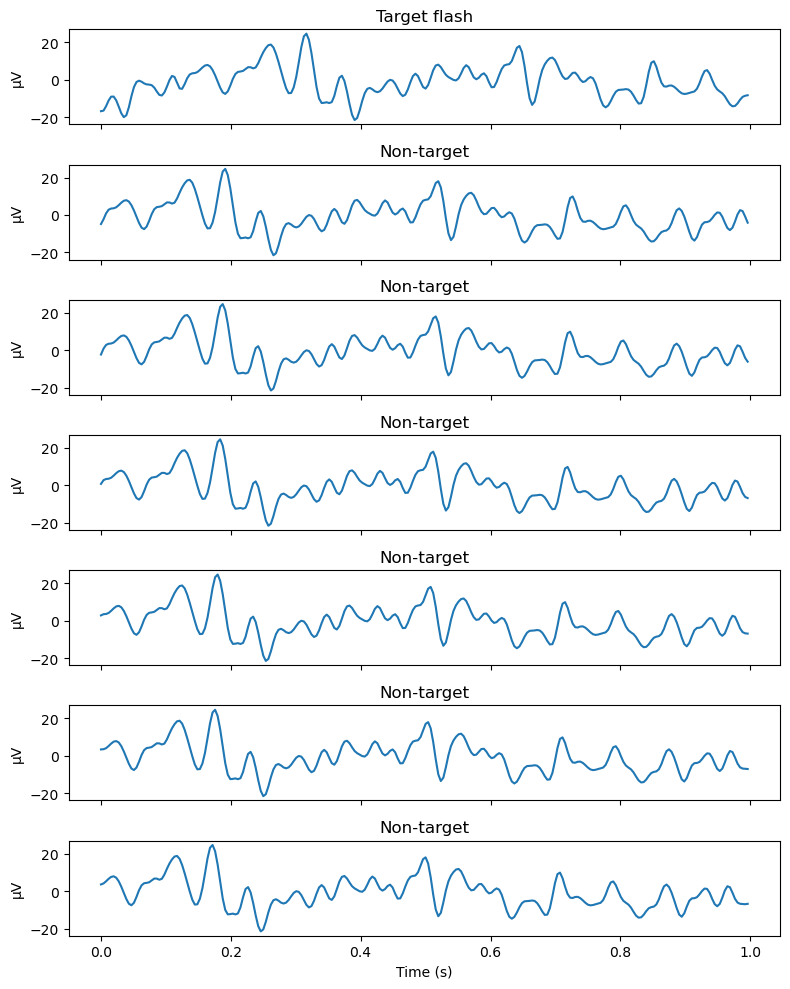

In [3]:
import numpy as np
import matplotlib.pyplot as plt

sfreq = raw.info["sfreq"]
code = raw.get_data(picks=raw.ch_names.index("StimulusCode"))[0]
type_ = raw.get_data(picks=raw.ch_names.index("StimulusType"))[0]
begin = raw.get_data(picks=raw.ch_names.index("StimulusBegin"))[0]
flashes = np.where(begin > 0)[0]
first_target = next(idx for idx in flashes if type_[idx] == 1)
non_targets = [idx for idx in flashes if idx > first_target and type_[idx] == 0][:6]
fig, axes = plt.subplots(7, 1, figsize=(8, 10), sharex=True)
segment = int(sfreq)
times = np.arange(segment) / sfreq
data = raw.get_data(picks="EEG_Cz")
axes[0].plot(times, data[0, first_target : first_target + segment] * 1e6)
axes[0].set_title("Target flash")
for ax, idx in zip(axes[1:], non_targets):
    ax.plot(times, data[0, idx : idx + segment] * 1e6)
    ax.set_title("Non-target")
for ax in axes:
    ax.set_ylabel("µV")
axes[-1].set_xlabel("Time (s)")
fig.tight_layout()

Apply a 0.1–30 Hz band-pass filter.

In [4]:
raw_filt = raw.copy().filter(0.1, 30.0)

Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 0.1 - 30 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal bandpass filter:


- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 0.10


- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)


- Upper passband edge: 30.00 Hz


- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


- Filter length: 8449 samples (33.004 s)


Compare the Cz channel before and after filtering.

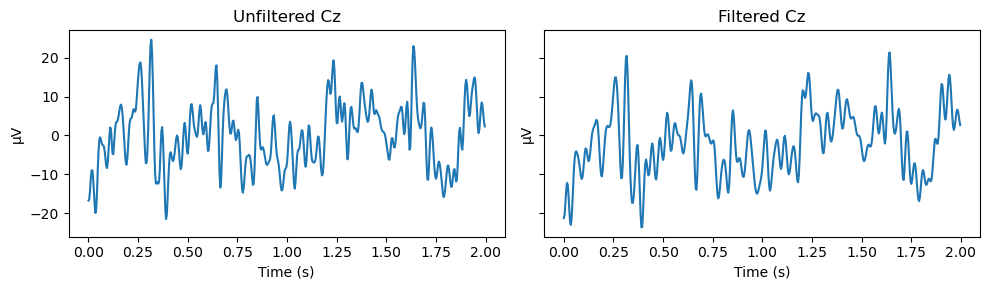

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
dur = int(sfreq * 2)
start = first_target
before = raw.get_data(picks="EEG_Cz", start=start, stop=start + dur)[0] * 1e6
after = raw_filt.get_data(picks="EEG_Cz", start=start, stop=start + dur)[0] * 1e6
t = np.arange(dur) / sfreq
axes[0].plot(t, before)
axes[0].set_title("Unfiltered Cz")
axes[1].plot(t, after)
axes[1].set_title("Filtered Cz")
for ax in axes:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("µV")
fig.tight_layout()

Plot the power spectral density to inspect frequency content.

Effective window size : 8.000 (s)


Plotting power spectral density (dB=True).


/tmp/ipykernel_8181/172394902.py:2: UserWarning: Zero value in spectrum for channels FakeFeedback, DisplayResults
  raw_filt.compute_psd(fmax=40).plot(average=True);
/tmp/ipykernel_8181/172394902.py:2: UserWarning: Infinite value in PSD for channels FakeFeedback, DisplayResults.
These channels might be dead.
  raw_filt.compute_psd(fmax=40).plot(average=True);


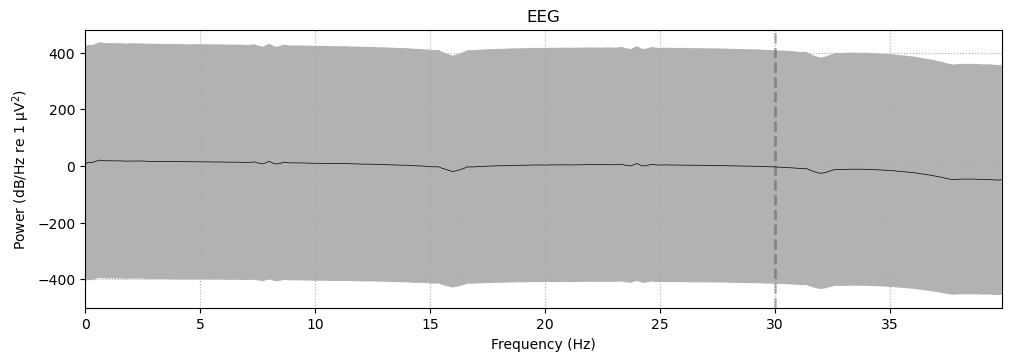

In [6]:
raw_filt.set_montage("biosemi64", match_case=False, on_missing="ignore")
raw_filt.compute_psd(fmax=40).plot(average=True);

## Key takeaways
- BigP3BCI files store raw EEG with many marker channels.
- Event markers allow extracting specific flashes.
- Band-pass filtering removes slow drift and high-frequency noise.
- PSD plots help judge overall signal quality.